# 1 案例描述
使用卷积神经网络对CIFAR10数据集进行分类

# 2 CIFAR10 数据集
#### ● CIFAR-10是一个用于识别普通物体的小型数据集，它包含了10个类别的RBG图
#### ● 图片尺寸：32 X 32
#### ● 训练图片50000张，测试图片10000张
#### ● https://www.cs.toronto.edu/~kriz/cifar.html

## 2.1 下载CIFAR数据集

In [1]:
%matplotlib inline
import urllib.request
import os
import tarfile
import time
import numpy as np
import pickle as p
import matplotlib.pyplot as plt
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # CUP

In [2]:
start = time.perf_counter()
def fun(blocknum,blocksize,totalsize):
    """
    blocknum:当前的块编号
    blocksize:每次传输的块大小
    totalsize:网页文件总大小
    """
    percent = blocknum*blocksize/totalsize
    
    if percent > 1.0:
        percent = 1.0
    percent = percent*100

    #print("\r Download : %.2f%%" %(percent), end="")
    #print("\r Download:{0:.2f}%".format(percent), end="")
    scale = int(percent/5)
    for i in range(scale+1):
        a = '*' * i
        b = '.' * (scale - i)
        c = percent
        dur = time.perf_counter() - start
        print("\r{:^3.2f}%[{}->{}]{:.2f}s".format(c,a,b,dur),end='')
    
# 下载
url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filepath = '/Users/lumin/Documents/dataset/cifar-10_data/cifar-10-python.tar.gz'
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url, filepath, fun)
    print('downloaded:',result)
else:
    print('Data file already exists.')

# 解压
if not os.path.exists("/Users/lumin/Documents/dataset/cifar-10_data/cifar-10-python.tar.gz"):
    tfile = tarfile.open("/Users/lumin/Documents/dataset/cifar-10_data/cifar-10-python.tar.gz",'r:gz')
    result = tfile.extractall('data/')
    print('Extracted to ./Users/lumin/Documents/dataset/cifar-10_data/cifar-10-batches-py/')
else:
    print('Directory already exists.')

Data file already exists.
Directory already exists.


## 2.2导入CIFAR数据集

In [3]:
def load_CIFAR_batch(filename):
    """load single batch of cifar"""
    with open(filename, 'rb')as f:
        #一个样本由标签和图像数据组成
        #<1 x label><3072 x pixel> (3072=32x32x3)
        #...
        #<1 x label><3072 x pixel>
        data_dict = p.load(f, encoding='bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        
        #把原始数据结构调整为：BCWH
        images = images.reshape(10000,3,32,32)
        
        #tensorflow处理图像数据的结构：BWHC
        #把通道数据C移动到最后一个维度
        images = images.transpose(0,2,3,1)
        
        labels = np.array(labels)
        
        return images,labels

def load_CIFAR_data(data_dir):
    """load CIFAR data"""
    
    images_train = []
    labels_train = []
    for i in range(5):
        f = os.path.join(data_dir, 'data_batch_%d' % (i+1))
        print('loading', f)
        
        #调用load_CIFAR_batch()获得批量的图像及其对应的标签
        image_batch,label_batch = load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)
        del image_batch,label_batch
    
    Xtest,Ytest = load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finished loadding CIFAR-10 data')
    
    #返回训练集的图像和标签，测试集的图像和标签
    return Xtrain,Ytrain,Xtest,Ytest

data_dir = '/Users/lumin/Documents/dataset/cifar-10_data/cifar-10-batches-py/'
Xtrain,Ytrain,Xtest,Ytest = load_CIFAR_data(data_dir)

loading /Users/lumin/Documents/dataset/cifar-10_data/cifar-10-batches-py/data_batch_1
loading /Users/lumin/Documents/dataset/cifar-10_data/cifar-10-batches-py/data_batch_2
loading /Users/lumin/Documents/dataset/cifar-10_data/cifar-10-batches-py/data_batch_3
loading /Users/lumin/Documents/dataset/cifar-10_data/cifar-10-batches-py/data_batch_4
loading /Users/lumin/Documents/dataset/cifar-10_data/cifar-10-batches-py/data_batch_5
finished loadding CIFAR-10 data


## 2.3 显示数据集信息

In [4]:
print('training data shape:', Xtrain.shape)
print('training labels shape:', Ytrain.shape)
print('test data shape:', Xtest.shape)
print('test labels shape:', Ytest.shape)

training data shape: (50000, 32, 32, 3)
training labels shape: (50000,)
test data shape: (10000, 32, 32, 3)
test labels shape: (10000,)


## 2.4 查看单项image和label

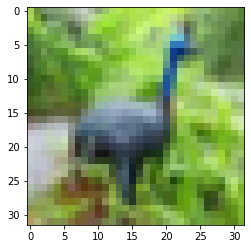

In [5]:
#查看image
plt.imshow(Xtrain[6])

In [6]:
#查看label
#对应类别信息可查看：http://www.cs.toronto.edu/~kriz/cifar.html
print(Ytrain[6])

2


## 2.5查看多项images与label

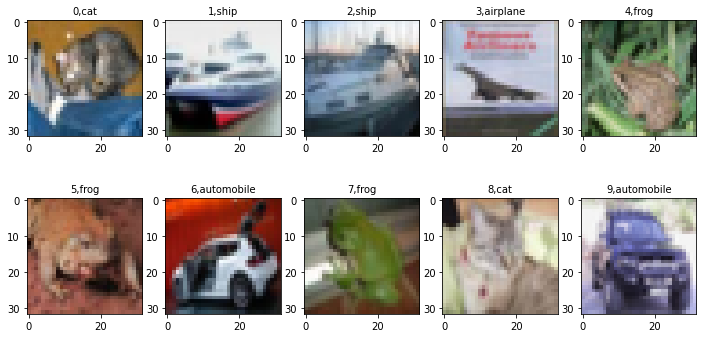

In [7]:
import matplotlib.pyplot as plt

# 定义标签字典，每一个数字所代表的图像类别的名称
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 
              5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

# 定义显示图像数据及其对应标签的函数
def plot_images_labels_prediction(images, labels, prediction, idx, num = 10):
    fig = plt.gcf()
    fig.set_size_inches(12, 6)
    if num > 10:
        num = 10
    for i in range(0, num):
        ax = plt.subplot(2, 5, 1+i)
        ax.imshow(images[idx], cmap = 'binary')
        
        title = str(i)+','+label_dict[labels[idx]]
        if len(prediction) > 0:
            title +='=>'+label_dict[prediction[idx]]
        
        ax.set_title(title, fontsize = 10)
        idx += 1
    plt.show()

# 显示图像数据及其对应标签
plot_images_labels_prediction(Xtest, Ytest, [], 0, 10)

# 3 数据预处理
## 3.1 图像数据预处理

In [8]:
# 查看图像数据信息
# 显示第一个图的第一个像素点
Xtrain[0][0][0]

array([59, 62, 63], dtype=uint8)

In [9]:
# 将图像进行数字标准化
Xtrain_normalize = Xtrain.astype('float32')/255.0
Xtest_normalize = Xtest.astype('float32')/255.0

In [10]:
# 查看预处理后图像数据信息
Xtrain_normalize[0][0][0]

array([0.23137255, 0.24313726, 0.24705882], dtype=float32)

## 3.2标签数据预处理

In [11]:
# 查看标签数据
Ytrain[:10]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

# 独热编码（One-Hot Encoding)
#### ●能够处理非连续型数值特征
#### ●在一定程度上也扩充了特征。比如性别本身是一个特征，经过one-hot编码以后，就变成了男或女两个特征.

In [12]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse = False)
yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
Ytrain_reshape = Ytrain.reshape(-1, 1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytest.reshape(-1, 1)
Ytest_onehot = encoder.transform(Ytest_reshape)

In [13]:
Ytrain_onehot.shape

(50000, 10)

In [14]:
Ytrain[:5]

array([6, 9, 9, 4, 1])

In [15]:
Ytrain_onehot[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
import tensorflow as tf
tf.reset_default_graph()

# 4 建立CIFAR-10图像分类模型
## 4.1 定义共享函数

In [17]:
# 定义权值
def weight(shape,w1):
    # 在构建模型时，需要使用tf.Variable来创建一个变量
    # 在训练时，这个变量不断更新
    # 使用函数tf.truncated_normal(截断的正态分布)生成标准差为0.1的随机数来初始化权值
    var = tf.Variable(tf.truncated_normal(shape,stddev=0.1),name='W')
    if w1 is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var),w1,name='weight_loss')
        tf.add_to_collection('losses',weight_loss)
    return var

# 定义偏置
# 初始化为0.1
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape = shape), name = 'b')

# 定义卷积操作
# 步长为1, padding为'SAME'
def conv2d(x, W):
    #tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

# 定义池化操作
# 步长为2, 即原尺寸的长和宽各除以2
def max_pool_2x2(x):
    #tf.nn.max_pool(value, ksize, strides, padding, name=None)
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

## 4.2 定义网络结构

In [18]:
# 输入层
# 32x32图像，通道为3(RGB)
with tf.name_scope('input_layer'):
    x = tf.placeholder('float', shape=[None, 32, 32, 3], name="x")

# 第1个卷积层
# 输入通道：3，输出通道：32，卷积后图像尺寸不变，依然是32x32
with tf.name_scope('conv_1'):
    W1 = weight([3,3,3,32],w1=0.0) #[k_width, k_height, input_chn, output_chn]
    b1 = bias([32]) #与output_chn一致
    conv_1 = conv2d(x, W1) + b1
    conv_1 = tf.nn.relu(conv_1)
# 第1个池化层
# 将32x32图像缩小为16x16, 池化不改变通道数量，因此依然是32个
with tf.name_scope('pool_1'):
    pool_1 = max_pool_2x2(conv_1)
norm1 = tf.nn.lrn(pool_1,4,bias=1.0,alpha=0.001/9.0,beta=0.75)
    
#第2个卷积层
#输入通道：32，输出通道：64，卷积后图像尺寸不变，依然是16x16
with tf.name_scope('conv_2'):
    W2 = weight([3,3,32,64],0.0)
    b2 = bias([64])
    conv_2 = conv2d(norm1, W2) + b2
    conv_2 = tf.nn.lrn(tf.nn.relu(conv_2),4,bias=1.0,alpha=0.001/9.0,beta=0.75)
#第2个池化层
#将16x16图像缩小为8x8, 池化不改变通道数量，因此依然是64个
with tf.name_scope('pool_2'):
    pool_2 = max_pool_2x2(conv_2)
    
#第3个卷积层
#输入通道：64，输出通道：128，卷积后图像尺寸不变，依然是8x8
with tf.name_scope('conv_3'):
    W3 = weight([3,3,64,128],w1=0.0)
    b3 = bias([128])
    conv_3 = conv2d(pool_2, W3) + b3
    conv_3 = tf.nn.relu(conv_3)
#第3个池化层
#将8x8图像缩小为4x4, 池化不改变通道数量，因此依然是128个
with tf.name_scope('pool_3'):
    pool_3 = max_pool_2x2(conv_3)

#全连接层
#将池第3个池化层128个4x4的图像转换为一维的向量，长度是128x4x4=2048
#256个神经元
with tf.name_scope('fc'):
    #全连接一层
    W4 = weight([2048, 256],w1=0.004) #256个神经元
    b4 = bias([256])
    flat = tf.reshape(pool_3, [-1,2048])
    h1 = tf.nn.relu(tf.matmul(flat, W4) + b4)
    
    #全连接二层
    W5 = weight([256,128],w1=0.004) #128个神经元
    b5 =  bias([128])
    h2 = tf.nn.relu(tf.matmul(h1,W5)+b5)
    h_dropout = tf.nn.dropout(h2,keep_prob=0.8)

#输出层
#输出层共有10个神经元，对应到0-9这10个类别
with tf.name_scope('output_layer'):
    W6 = weight([128, 10],w1=0.0)
    b6 = bias([10])
    pred = tf.nn.softmax(tf.matmul(h_dropout, W6) + b6)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 4.3 构建模型

In [19]:
with tf.name_scope("labels"):
    # 定义占位符
    y = tf.placeholder('float',shape=[None,10],name='label')

In [20]:
# 定义损失函数
with tf.name_scope("loss"):
    loss_mse = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
    loss_function = loss_mse+tf.add_n(tf.get_collection('losses'))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [21]:
# 选择优化器
with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss_function)

## 4.4 定义准确率

In [22]:
with tf.name_scope("evaluation"):
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# 5 训练模型
## 5.1 启动会话

In [23]:
from time import time

train_epochs = 40
batch_size = 50
total_batch = int(len(Xtrain)/batch_size)
epoch_list = []; accuracy_list=[]; loss_list=[];
epoch = tf.Variable(0, name='epoch', trainable=False)

startTime = time()

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

## 5.2 断点续训

In [24]:
#设置检查点存储目录
ckpt_dir = "/Users/lumin/Documents/dataset/cifar-10_data/CIFAR10_log/"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

#生成saver
saver = tf.train.Saver(max_to_keep = 1)

#如果有检查点文件，读取最新的检查点文件，恢复各种变量值
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt != None:
    saver.restore(sess, ckpt) #加载所有的参数
    # 从这里开始就可以直接使用模型进行预测,或者接着继续训练了
else:
    print("Traing from scratch.")

# 获取续训参数
start = sess.run(epoch)
print("Trainig starts form {} epoch.".format(start + 1))

Traing from scratch.
Trainig starts form 1 epoch.


## 5.3 迭代训练

In [25]:
def get_train_batch(number, batch_size):
    return Xtrain_normalize[number*batch_size:(number+1)*batch_size],\
           Ytrain_onehot[number*batch_size:(number+1)*batch_size]
for ep in range(start, train_epochs):
    
    for i in range(total_batch):
        batch_x, batch_y = get_train_batch(i,batch_size)
        sess.run(optimizer,feed_dict={x: batch_x, y: batch_y})
        if i % 100 == 0:
            print("Step {}".format(i), "finished")
    
    loss, acc = sess.run([loss_function, accuracy], feed_dict = {x: batch_x, y: batch_y})
    epoch_list.append(ep+1)
    loss_list.append(loss);
    accuracy_list.append(acc)
    
    print("Train epoch:", '%02d' % (sess.run(epoch)+1), "Loss=","{:.6f}".format(loss),"Accuracy=",acc)
    
    #保存检查点
    saver.save(sess,ckpt_dir+"CIFAR10_cnn_model.cpkt",global_step=ep+1)
    sess.run(epoch.assign(ep+1))

duration = time()-startTime
print("Train Finished takes:","{:.2f}秒".format(duration))

Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 01 Loss= 2.205846 Accuracy= 0.3
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 02 Loss= 2.116901 Accuracy= 0.38
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 03 Loss= 2.032096 Accuracy= 0.48
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 04 Loss= 1.974946 Accuracy= 0.54
Step 0 finished
Step 

Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 36 Loss= 1.717027 Accuracy= 0.78
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 37 Loss= 1.795839 Accuracy= 0.7
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 38 Loss= 1.770929 Accuracy= 0.74
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 39 Loss= 1.761791 Accuracy= 0.76
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finish

### 改进方式（根据个人可利用的计算资源）：
    ● 增加网络层数
    ● 增加迭代次数
    ● 增加全连接层数
    ● 增加全连接层的神经元个数
    ● 数据扩增，等等

## 5.4 可视化损失值

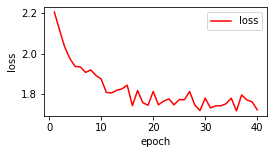

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list, loss_list, color = 'red', label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc = 'upper right')

## 5.5 可视化准确率

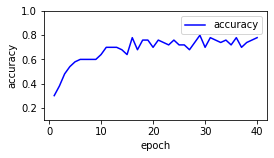

In [27]:
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list,accuracy_list, color = 'blue', label="accuracy")
plt.ylim(0.1,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# 6 评诂模型及预测
## 6.1 计算测试集上的准确率

In [28]:
test_total_batch = int(len(Xtest_normalize)/batch_size)
test_acc_sum = 0.0
for i in range(test_total_batch):
    test_image_batch = Xtest_normalize[i*batch_size:(i+1)*batch_size]
    test_label_batch = Ytest_onehot[i*batch_size:(i+1)*batch_size]
    test_batch_acc = sess.run(accuracy, feed_dict = {x: test_image_batch, y: test_label_batch})
    test_acc_sum += test_batch_acc
test_acc = float(test_acc_sum/test_total_batch)
print("Test accuracy:{:.6f}".format(test_acc))

Test accuracy:0.693200


## 6.2 利用模型进预测

In [29]:
test_pred = sess.run(pred, feed_dict={x: Xtest_normalize[:10]})
prediction_result = sess.run(tf.argmax(test_pred, 1))

## 6.3 可视化预测结果

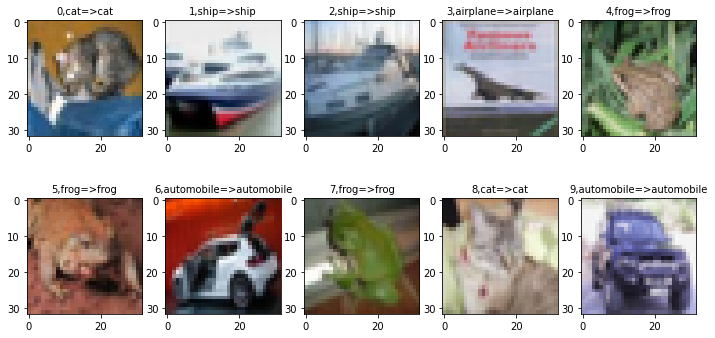

In [30]:
plot_images_labels_prediction(Xtest,Ytest,prediction_result, 0, 10)